In [1]:
import jax.numpy as np
from utils import MidpointNormalize, load_data
from jax import random, flatten_util, vjp, jvp, custom_vjp, jacfwd, jacrev, vmap, grad
from IFD_tsne import tsne_fwd
import jax
import matplotlib.pylab as plt
import seaborn as sns

In [13]:
# Pairwise squared Euclidean distance
def get_dists(Z):
    """
    Compute all pairwise distances of each data points z_i in Z.
    
    Params:
        Z: matrix with n rows. Each row is the z_i
        
    Return:
        All pairwise distances of each data points z_i in Z
    """

    
    diff = Z[:, :, None] - Z[:, :, None].T
    return (np.square(diff)).sum(1)

def perp_fn(i, beta_i, dists, perplexity_function):
    """
    Function that takes an index i, beta_i, and all pairwise distances of X
    and return the perplexity of p_{j|i} (Eq. 1 in the paper).
    """
    exp_dists = np.exp(-dists[i] / beta_i)
    exp_dists.at[i].set(0.)
    p_j_given_i = exp_dists / exp_dists.sum()

    perp_i = perplexity_function(p_j_given_i)

    return perp_i

def binary_search(perp, dists, perplexity_function):
    """
    Let beta_i := 2 \sigma_i^2. This function computes (beta_i) that achieve
    the desired perplexity.
    
    Params:                 
        perp: Desired perplexity value.
        
        dists: Pairwise squared Euclidean distances, stored in an (n x n)-matrix
        
        perplexity_function: A function that return the perplexity number given a probability vector
        
    Returns:
        betas: (n,) array of beta_i's 
    """    
    n = len(dists)
    betas = []
    
    for i in range(n):
        # Binary search
        min_beta, max_beta = 1e-10, 1e10

        for _ in range(1000):
            mid_beta = (min_beta + max_beta) / 2
            p_mid = perp_fn(i, mid_beta, dists, perplexity_function)

            if p_mid >= perp:
                max_beta = mid_beta
            else:
                min_beta = mid_beta

            # Close enough, use the current mid value
            if np.abs(p_mid - perp) < 1e-3:
                break
                
        betas.append(mid_beta)

    return np.array(betas)

def get_perplexity(p):
    """
    Returns the perplexity of p. See https://en.wikipedia.org/wiki/Perplexity
    
    Params:
        p: probability vector
        
    Return:
        A single number---the perplexity of p
    """
    entropy = -np.sum(p * np.log2(p + 1e-10))
    return 2**entropy


def get_beta(perp, dists_X):
    """
    Let beta_i := 2 \sigma_i^2. This function computes (beta_i) that achieve
    the desired perplexity.
    
    Params:                 
        perp: Desired perplexity value.
        
        dists_X: Pairwise squared Euclidean distances between points in X, stored in an (n x n)-matrix
                
    Returns:
        betas: (n,) array of beta_i's 
    """    
    return binary_search(perp, dists_X, get_perplexity)

def logSoftmax(x, i):
    """Compute softmax for vector x."""
    max_x = np.max(x)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x)
    log_sum_exp_x = np.log(sum_exp_x)
    max_plus_log_sum_exp_x = max_x + log_sum_exp_x
    log_probs = x - max_plus_log_sum_exp_x

    # Recover probs
    exp_log_probs = np.exp(log_probs)
    exp_log_probs = exp_log_probs.at[i].set(0.)
    sum_log_probs = np.sum(exp_log_probs)
    probs = exp_log_probs / sum_log_probs
    return probs

def get_p_j_given_i(dists_X, perp):
    """
    Compute the conditional probabilities p_{j|i}'s
    
    Params
        dists_X: pairwise-distances matrix of X
        perp: the desired perplexity level (single number)

    Return:
        (n, n) matrix containing p_{j|i}'s
    """
    betas = get_beta(perp, jax.lax.stop_gradient(dists_X))
    
    p_j_given_i = []
    for i, j in enumerate(betas):
        p_j_given_i.append(logSoftmax(-dists_X[i] / (j), i))
    return np.array(p_j_given_i)
    

def x2p(dists_X, perp):
    """
    Compute the joint probabilities p_ij's
    
    Params
        dists_X: pairwise-distances matrix of X
        perp: the desired perplexity level (single number)

    Return:
        (n, n) matrix P containing p_ij's
    """
    n = len(dists_X)
    p_j_given_i = get_p_j_given_i(dists_X, perp)
    p_i_given_j = p_j_given_i.T
    P = (p_j_given_i + p_i_given_j) / (2*n)
    #P = (p_j_given_i + p_i_given_j) / (np.sum(p_i_given_j))
    return P

def y2q(dists_Y):    
    """
    Compute low-dimensional affinities q_ij
    
    Params
        dists_Y: (n, n) matrix containing all pairwise distances of elements of Y

    Return:
        (n, n) matrix Q containing q_ij's
    """
    Q = 1./(1. + dists_Y)
    Q = Q.at[np.diag_indices_from(Q)].set(0.)
    Q /= Q.sum()
    
    return Q

In [14]:
def KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30)
    dists_X = get_dists(X)
    P = x2p(dists_X, perplexity)
    P = np.maximum(P, 1e-12)
    #print('P', P)
    dists_Y = get_dists(Y)
    Q = y2q(dists_Y)
    Q = np.maximum(Q, 1e-12)
    #print('Q', Q)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [15]:
X, y = load_data(50)
key = random.PRNGKey(41)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.8816, 50 iterations in 0.3250 sec
Iteration  100, KL divergence 0.9012, 50 iterations in 0.2848 sec
Iteration  150, KL divergence 0.9352, 50 iterations in 0.3087 sec
Iteration  200, KL divergence 0.9408, 50 iterations in 0.3382 sec
Iteration  250, KL divergence 0.9399, 50 iterations in 0.3147 sec
   --> Time elapsed: 1.57 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.1367, 50 iterations in 0.3044 sec
Iteration  100, KL divergence 0.1351, 50 iterations in 0.2899 sec
Iteration  150, KL divergence 0.1351, 50 iterations in 0.2595 sec
Iteration  200, KL divergence 0.1351, 50 iterations in 0.2579 sec
Iteration 

In [16]:
KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener)

Array(0.11029205, dtype=float32)

In [17]:
J_X_Y = jacfwd(jacfwd(KL_divergence, argnums=1), argnums=0)(X_flat, Y_flat, X_unflattener, Y_unflattener)
print('J', J_X_Y)

J [[-4.24462851e-05 -1.48027670e-03  2.48451077e-04 ... -3.42164185e-07
   1.14006536e-06  1.27201304e-07]
 [ 1.50410214e-03  3.26412875e-04 -2.95569131e-04 ... -4.40377335e-09
  -4.28170461e-06 -7.44806982e-07]
 [ 4.69437146e-05  1.37148636e-05 -6.14862256e-06 ... -1.73947137e-05
   2.04412754e-06  5.77533910e-06]
 ...
 [-2.89589043e-05 -1.28471538e-05 -2.56100566e-06 ... -3.74666547e-06
  -5.38957647e-06  1.02705144e-06]
 [-1.48657155e-05  2.08864549e-07  1.74894922e-07 ... -4.92571962e-05
   1.61192351e-04  2.48848664e-05]
 [ 1.43041452e-05  6.70935242e-06 -6.37701305e-07 ...  5.81944987e-05
  -7.65324367e-05  5.43743517e-05]]


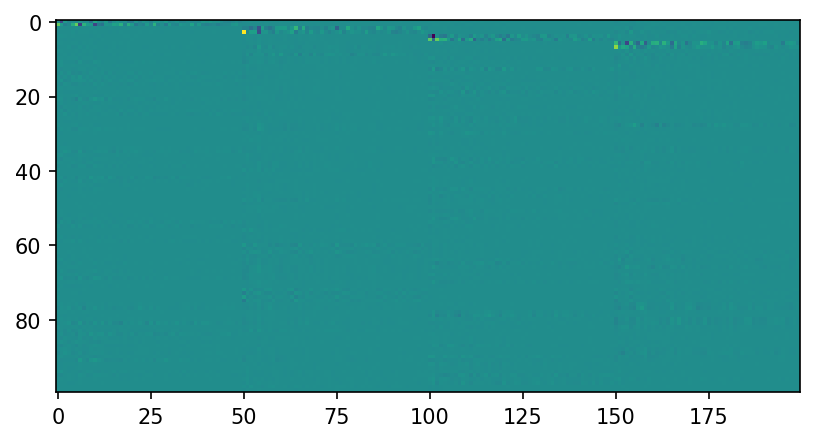

In [18]:
plt.imshow(J_X_Y[:, 0:200])

In [14]:
H = jax.hessian(KL_divergence, argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)

P [[1.0000000e-12 5.3637329e-04 3.3646161e-04 ... 4.5052939e-04
  1.8643361e-04 2.8939545e-04]
 [5.3637329e-04 1.0000000e-12 2.6181966e-04 ... 2.0451154e-04
  2.0844104e-04 2.8318496e-04]
 [3.3646161e-04 2.6181966e-04 1.0000000e-12 ... 2.6609431e-04
  2.0896769e-04 2.5835019e-04]
 ...
 [4.5052939e-04 2.0451154e-04 2.6609431e-04 ... 1.0000000e-12
  1.1951862e-04 1.3231787e-04]
 [1.8643361e-04 2.0844104e-04 2.0896769e-04 ... 1.1951862e-04
  1.0000000e-12 8.5519301e-04]
 [2.8939545e-04 2.8318496e-04 2.5835019e-04 ... 1.3231787e-04
  8.5519301e-04 1.0000000e-12]]
Q Traced<ConcreteArray([[9.99999996e-13 3.82294267e-04 3.18798120e-04 ... 5.11404534e-04
  1.95884189e-04 3.25079338e-04]
 [3.82294267e-04 9.99999996e-13 1.31562483e-04 ... 3.78778408e-04
  8.98419021e-05 1.34447371e-04]
 [3.18798120e-04 1.31562483e-04 9.99999996e-13 ... 4.32623434e-04
  9.86198720e-05 1.20241464e-04]
 ...
 [5.11404534e-04 3.78778408e-04 4.32623434e-04 ... 9.99999996e-13
  8.69829091e-05 1.20011275e-04]
 [1.958841

In [19]:
from simplified_tsne_jax import * 
def KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    #print('P', P)
    Q, _ = y2q(Y)
    #print('Q', Q)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [20]:
KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array(0.13507721, dtype=float32)

In [21]:
#f = lambda X, Y: KL_divergence(X, Y, X_unflattener, Y_unflattener)
J_X_Y = jacfwd(jacfwd(KL_divergence, argnums=1), argnums=0)(X_flat, Y_flat, X_unflattener, Y_unflattener)
print(J_X_Y)

Computing pairwise distances...
Starting binary search
Entered binary search function
[[ 6.14068995e-05 -1.60772807e-03  1.61214732e-04 ... -2.61638661e-07
   1.38574489e-06  3.80781842e-07]
 [ 1.96551671e-03  3.55698838e-04 -4.16464900e-04 ... -5.58400188e-07
  -5.54301641e-06 -2.43306317e-06]
 [ 4.72459615e-05  1.10221990e-05 -4.67542168e-06 ... -2.57087886e-05
   7.92594710e-06  1.25579145e-05]
 ...
 [-3.68587462e-05 -1.35654655e-05 -2.98978034e-06 ... -3.14628028e-06
  -6.87834654e-06  5.14021963e-08]
 [-2.38057437e-05  3.72923409e-07 -1.16308183e-06 ... -8.23647497e-05
   3.42344050e-04  9.08632792e-05]
 [ 1.15619550e-05  5.75941476e-06  4.26505721e-07 ...  6.08842602e-05
  -7.72744752e-05  6.87854626e-05]]


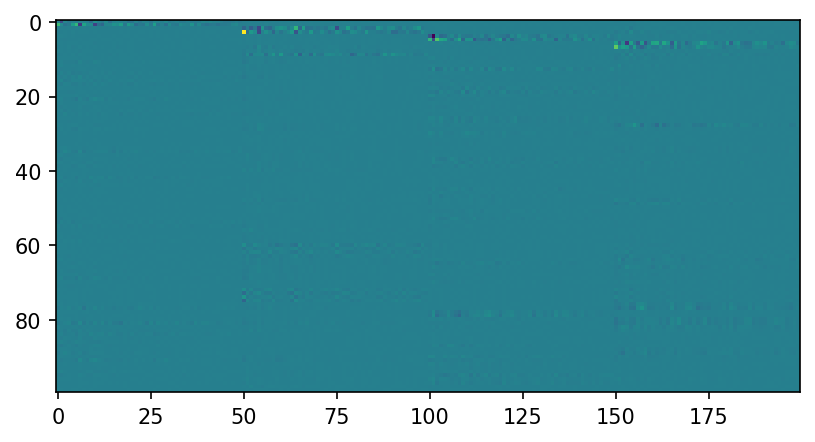

In [22]:
plt.imshow(J_X_Y[:, 0:200])

In [11]:
print(jacfwd(KL_divergence, argnums=0)(X_flat, Y_flat, X_unflattener, Y_unflattener))

Computing pairwise distances...
Starting binary search
Entered binary search function
[0. 0. 0. ... 0. 0. 0.]
